In [1]:
!pip install pytorch-ignite -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 8.4 MB/s eta 0:00:00


In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers


In [3]:
DATA_DIR='./data' # データ保存用のディレクトリ
IMAGE_SIZE = 32 # 入力画像1辺のサイズ
NUM_CLASSES = 100 # 分類するクラスの数
NUM_WORKERS = 8 # データローダーが使用するサブプロセスの数を指定
BATCH_SIZE = 32 # ミニバッチのサイズ
LEARNING_RATE = 1e-3 # 最大学習率
WEIGHT_DECAY = 1e-2 # オプティマイザーの重み減衰率
EPOCHS = 150 # 学習回数


In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)


device: cuda


In [5]:
# トレーニングデータに適用する一連の変換操作をtransforms.Composeにまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右反転
    # 4ピクセルのパディングを挿入してランダムに切り抜く
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    # 画像のコントラスト、彩度、色相をランダムに変化させる
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor() # テンソルに変換
])


In [6]:
# CIFAR-100データセットのトレーニングデータを読み込み、データ拡張を適用
train_dset = datasets.CIFAR100(
    root=DATA_DIR, train=True, download=True, transform=train_transform)
# CIFAR-100データセットのテストデータを読み込んでテンソルに変換する処理のみを行う
test_dset = datasets.CIFAR100(
    root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 169001437/169001437 [00:03<00:00, 42382813.63it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# トレーニング用のデータローダーを作成
train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 抽出時にシャッフルする
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )

# テスト用のデータローダーを作成
test_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    shuffle=False, # 抽出時にシャッフルしない
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )


In [8]:
class RelativePosEnc(nn.Module):
    """ 特徴マップへの相対位置エンコーディングの埋め込みを行うモジュール

    Attributes:
        pos_h (nn.Parameter): 高さ方向の相対位置エンコーディング
        pos_w (nn.Parameter): 幅方向の相対位置エンコーディング
    """
    def forward(self, q):
        """
        Args:
            q: 入力される特徴マップ
               (bs, ヘッド数, チャンネル数, 高さ, 幅)
               (bs, 4, 64, 8, 8), (bs, 4, 128, 4, 4)
        Returns:
            pos_enc: 相対位置エンコーディングが適用されたテンソル
        """
        # 相対位置エンコーディングとして学習可能なパラメーターを作成
        # RelativePosEncのインスタンスにpos_h属性が存在しない場合に作成する
        # pos_hとpos_wの形状: チャンネル数=64, 高さ,幅=8の場合は(15, 64)
        #                      チャンネル数=128, 高さ,幅=4の場合は(7, 128)
        if not hasattr(self, 'pos_h'):
            c, h, w = q.shape[-3:]  # 入力のチャンネル数、高さ、幅を取得
            # 高さ方向の相対位置エンコーディングの初期化
            self.pos_h = nn.Parameter(torch.zeros(2 * h - 1, c, device=q.device))
            # 幅方向の相対位置エンコーディングの初期化
            self.pos_w = nn.Parameter(torch.zeros(2 * w - 1, c, device=q.device))

        # 入力テンソルqの高さの次元に相対位置エンコーディングを適用
        # rel_h: (bs, ヘッド数, 幅, 2 * 高さ - 1, 高さ)
        #        (bs, 4, 8, 15, 8), (bs, 4, 4, 7, 4)
        rel_h = self.pos_h @ q.movedim(4, 2)
        # 入力テンソルqの幅の次元に相対位置エンコーディングを適用
        # rel_w: (bs, ヘッド数, 高さ, 2 * 幅 - 1, 幅)
        #        (bs, 4, 8, 15, 8), (bs, 4, 4, 7, 4)
        rel_w = self.pos_w @ q.movedim(3, 2)

        # 相対位置エンコーディングを絶対位置エンコーディングに変換
        # rel_h,rel_wの形状: (bs, 4, 8, 8, 8), (bs, 4, 4, 4, 4)
        rel_h = self.rel_to_abs(rel_h).movedim(2, 4)
        rel_w = self.rel_to_abs(rel_w).movedim(2, 3)

        # 高さ方向と幅方向のエンコーディングを組み合わせる
        # pos_encの形状: (bs, 4, 8, 8, 8, 8), (bs, 4, 4, 4, 4, 4)
        pos_enc = rel_h[:, :, :, None] + rel_w[:, :, None, :]

        # 最後の2つの次元をフラット化した後、
        # テンソルの第3次元と第4次元を1つに結合
        # pos_enc: (bs, 4, 8, 8, 8, 8)->(32, 4, 64, 64)
        #          (bs, 4, 4, 4, 4, 4)->(32, 4, 16, 16)
        pos_enc = pos_enc.flatten(-2).flatten(2, 3)

        return pos_enc

    @staticmethod
    def rel_to_abs(x):
        """ 相対位置エンコーディングを絶対位置に基づいたエンコーディングに変換する

        Args:
            x : 相対位置エンコーディングが適用されたテンソル
                ・(bs, ヘッド数, 幅, 2 * 高さ - 1, 高さ)
                ・(bs, ヘッド数, 高さ, 2 * 幅 - 1, 幅)
                  (bs, 4, 8, 15, 8), (bs, 4, 4, 7, 4),
        Returns:
            x: 絶対位置エンコーディングに変換したたテンソル
               (bs, 4, 8, 8, 8), (bs, 4, 4, 4, 4),
        """
        shape = x.shape # 入力テンソルの形状を取得
        length = shape[-1] # 最後の次元(高さ,または幅)のサイズを取得

        # 入力テンソルxの第2次元にゼロパディングを追加
        # (bs, ヘッド数, 高さ(または幅), 2*length-1, length)から
        # (bs, ヘッド数, 高さ(または幅), 2*length, length) へ変換
        # (bs, 4, 8, 15, 8)-->(32, 4, 8, 16, 8)
        # (bs, 4, 4, 7, 4)-->(32, 4, 4, 8, 4)
        x = F.pad(x, (0, 0, 0, 1))

        # (..., 2*length, length)から(..., 2*length**2)へ変換
        # (32, 4, 8, 16, 8)-->(bs, 4, 8, 128)
        # (32, 4, 4, 8, 4)-->(bs, 4, 4, 32)
        x = x.flatten(-2)

        # (..., 2*length**2) から (..., 2*length**2+length-1) へパディング
        # (bs, 4, 8, 128)-->(bs, 4, 8, 135)
        # (bs, 4, 4, 32)-->(bs, 4, 4, 35)
        x = F.pad(x, (0, length-1))

        # (..., 2*length**2+length-1)から(..., 2*length-1, length+1)へリシェイプ
        # (bs, 4, 8, 135)-->(bs, 4, 8, 15, 9)
        # (bs, 4, 4, 35)-->(bs, 4, 4, 7, 5)
        x = x.view(*shape[:-1], length+1)

        # テンソル x の最後の2つの次元に対してスライシングを行い、
        # 相対位置エンコーディングから絶対位置エンコーディングにするために
        # 必要な部分を抽出
        # スライシング後の形状: (bs, ヘッド数, length, length)
        # (bs, 4, 8, 15, 9)-->(bs, 4, 8, 8, 8)
        # (bs, 4, 4, 7, 5)-->(bs, 4, 4, 4, 4)
        x = x[..., length-1:, :length]

        return x


In [9]:
class AbsolutePosEnc(nn.Module):
    """ 入力テンソルに対して絶対位置エンコーディングを適用するモジュール

    Attributes:
        pos_h (nn.Parameter): 高さ方向の絶対位置エンコーディング
        pos_w (nn.Parameter): 幅方向の絶対位置エンコーディング
    """
    def forward(self, q):
        """
        Args:
            q (torch.Tensor): 入力される特徴マップ
                (bs, ヘッド数, チャンネル数, 高さ, 幅)
        Returns:
            pos_enc: 絶対位置エンコーディングが適用されたテンソル
        """
        # 高さ方向と幅方向の絶対位置エンコーディングが未定義の場合に作成
        if not hasattr(self, 'pos_h'):
            # 入力のチャンネル数、高さ、幅を取得
            c, h, w = q.shape[-3:]
            # 高さ方向の絶対位置エンコーディングの初期化
            self.pos_h = nn.Parameter(torch.zeros(h, c, device=q.device))
            # 幅方向の絶対位置エンコーディングの初期化
            self.pos_w = nn.Parameter(torch.zeros(w, c, device=q.device))

        # 高さ方向と幅方向の絶対位置エンコーディングを加算して pos_enc を作成
        pos_enc = self.pos_h[:, None] + self.pos_w[None, :]
        # pos_enc をフラット化し、q をフラット化して行列積を計算
        pos_enc = pos_enc.flatten(0, 1) @ q.flatten(-2)

        # 結果のpos_encを返す
        return pos_enc


In [10]:
class SelfAttention2d(nn.Module):
    """ 2次元の自己注意機構(Multi-Head Self-Attention)を実装するモジュール

    Attributes:
        heads (int): 注意ヘッドの数
        q_channels (int): クエリのチャンネル数
        scale (float): スケール因子
        to_pos_enc (nn.Module): 位置エンコーディングを生成するモジュール
        to_keys (nn.Conv2d): 入力をキーに変換する畳み込み層
        to_queries (nn.Conv2d): 入力をクエリに変換する畳み込み層
        to_values (nn.Conv2d): 入力をバリューに変換する畳み込み層
        unifyheads (nn.Conv2d): 注意ヘッドを統合するための畳み込み層
        attn_drop (nn.Dropout): 注意マップに適用するドロップアウト
        resid_drop (nn.Dropout): 出力に適用するドロップアウト
    """
    def __init__(self, in_channels, out_channels,
                 q_channels, v_channels, heads, pos_enc, p_drop=0.):
        """
        Args:
            in_channels (int): 入力のチャンネル数
            out_channels (int): 出力のチャンネル数
            q_channels (int): クエリのチャンネル数
            v_channels (int): バリューのチャンネル数
            heads (int): ヘッドの数
            pos_enc (nn.Module): 位置エンコーディング(位置情報)を生成するモジュール
                                 RelativePosEncモジュールが渡される
            p_drop (float): ドロップアウト率
        """
        super().__init__()
        self.heads = heads # ヘッドの数を設定
        self.q_channels = q_channels # クエリのチャンネル数を設定
        self.scale = q_channels ** -0.5 # スケーリングのための係数を計算
        self.to_pos_enc = pos_enc() # 位置エンコーディングのモジュールを初期化

        # キーを生成するための1×1畳み込み層
        # 入力チャネル数: in_channels
        # 出力チャンネル数(フィルターの数): q_channels * heads
        self.to_keys = nn.Conv2d(in_channels, q_channels * heads, 1)
        # クエリを生成するための1×1畳み込み層
        # 入力チャネル数: in_channels
        # 出力チャンネル数(フィルターの数): q_channels * heads
        self.to_queries = nn.Conv2d(in_channels, q_channels * heads, 1)
        # バリューを生成するための1×1畳み込み層
        # 入力チャネル数: in_channels
        # 出力チャンネル数(フィルターの数): v_channels * heads
        self.to_values = nn.Conv2d(in_channels, v_channels * heads, 1)
        # 複数のヘッドの出力を統合するための1×1畳み込み層
        # 入力チャネル数: heads * v_channels
        # 出力チャンネル数(フィルターの数): out_channels
        self.unifyheads = nn.Conv2d(v_channels * heads, out_channels, 1)

        # ドロップアウトを初期化
        self.attn_drop = nn.Dropout(p_drop)
        self.resid_drop = nn.Dropout(p_drop)

    def forward(self, x):
        """ フォワードパス

        Args:
            x: 入力テンソル (bs, チャンネル数, 高さ, 幅)
                            (bs, 256, 8, 8)
                            (bs, 512, 4, 4)
        Returns:
            out: MHSAによって生成された新しい特徴
                 (bs, 256, 8, 8)
                 (bs, 512, 4, 4)
        """
        b, _, h, w = x.shape  # 入力テンソルの形状を取得

        # 入力テンソルxからキー、クエリ、バリューを生成
        # keysの形状: h,w=8の場合(bs, 4, 64, 64)
        #             h,w=4の場合(32, 4, 128, 16)
        keys = self.to_keys(x).view(b, self.heads, self.q_channels, h * w)
        # queriesの形状: h,w=8の場合(bs, 4, 64, 8, 8)
        #                h,w=4の場合(32, 4, 128, 4, 4)
        queries = self.to_queries(x).view(b, self.heads, self.q_channels, h, w)
        # valuesの形状: h,w=8の場合(bs, 4, 64, 64)
        #               h,w=4の場合(bs, 4, 128, 16)
        values = self.to_values(x).view(b, self.heads, -1, h * w)

        # RelativePosEncモジュールを利用して
        # 位置エンコーディングを生成し、クエリに追加
        # pos_encの形状: h,w=8の場合(bs, 4, 64, 64)
        #                h,w=4の場合(bs, 4, 16, 16)
        pos_enc = self.to_pos_enc(queries)

        # queriesの高さと幅の次元をフラット化して1つの次元にまとめる
        # queriesの形状: h,w=8の場合(bs, 4, 64, 64)
        #                h,w=4の場合(bs, 4, 128, 16)
        queries = queries.flatten(-2)

        # クエリに位置エンコーディングを埋め込み、
        # キーとの行列積で注意マップ(アテンションスコアに相当)を計算
        # attの形状: h,w=8の場合(bs, 4, 64, 64)
        #            h,w=4の場合(bs, 4, 16, 16)
        # (32, 4, 64, 64)(32, 4, 16, 16)
        att = keys.transpose(-2, -1) @ queries + pos_enc

        # 注意マップをスケーリングし、チャンネル次元にソフトマックスを適用
        # クエリとキーとの相関値を確率分布に変換
        # attの形状: h,w=8の場合(bs, 4, 64, 64)
        #            h,w=4の場合(bs, 4, 16, 16)
        att = F.softmax(att * self.scale, dim=-2)

        # ドロップアウト
        # (32, 4, 64, 64)(32, 4, 16, 16)
        att = self.attn_drop(att)

        # バリューと注意マップの行列積を計算
        # outの形状: h,w=8の場合(bs, 4, 64, 64)
        #            h,w=4の場合(bs, 4, 128, 16)
        out = values @ att

        # outの形状:(bs, ヘッド数, チャンネル数, h * w)を
        # (bs, チャンネル数(自動計算), h, w)にすることでヘッド数を統合する
        #
        # outの形状: h,w=8の場合(bs, 256, 8, 8)
        #            h,w=4の場合(bs, 512, 4, 4)
        out = out.view(b, -1, h, w)

        # Conv2dレイヤーで複数のヘッドからの出力を統合する
        # outの形状: h,w=8の場合(bs, 256, 8, 8)
        #            h,w=4の場合(bs, 512, 4, 4)
        out = self.unifyheads(out)
        # ドロップアウトを適用
        out = self.resid_drop(out)

        return out


In [11]:
class AttentionBlock(nn.Sequential):
    """ 自己注意機構(SelfAttention2d)のブロック化

    SelfAttention2dモジュール、バッチ正規化層、
    ReLU活性化関数を配置
    """
    def __init__(self, channels, heads=4, p_drop=0.):
        """
        Args:
            channels (int): 入力および出力のチャネル数
            heads (int): ヘッドの数（デフォルトは4）
            p_drop (float): ドロップアウト率（デフォルトは0）
        """
        # 入力チャネル数を注意ヘッドの数で割り、クエリのチャネル数を計算
        q_channels = channels // heads
        super().__init__(
            # SelfAttention2dモジュールを配置
            # 位置エンコーディングを生成するモジュールとしてRelativePosEncを渡す
            SelfAttention2d(
                channels, channels, q_channels, q_channels, heads,
                RelativePosEnc, p_drop),
            nn.BatchNorm2d(channels), # バッチ正規化層を配置
            nn.ReLU(inplace=True) # ReLU活性化関数を適用
        )


In [12]:
class ConvBlock(nn.Sequential):
    """ ボトルネック構造に用いる畳み込みブロック
        畳み込み層、バッチ正規化層、ReLU活性化関数で構成される

    """
    def __init__(self, in_channels, out_channels,
                 kernel_size=3, stride=1, act=True):
        """
        Args:
            in_channels (int): 入力チャンネル数
            out_channels (int): 出力チャンネル数
            kernel_size (int): 畳み込みカーネルのサイズ（デフォルトは3）
            stride (int): 畳み込みのストライド（デフォルトは1）
            act (bool): ReLU活性化関数を適用するかどうか（デフォルトはTrue）
        """
        # パディングを計算してカーネルサイズが奇数の場合に出力のサイズを保持
        padding = (kernel_size - 1) // 2
        layers = [
            # 畳み込み層を配置
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size, stride=stride, padding=padding, bias=False),
            # バッチ正規化層を配置
            nn.BatchNorm2d(out_channels)
        ]
        if act:
            # actがTrueの場合、ReLU活性化関数を追加
            layers.append(nn.ReLU(inplace=True))

        # スーパークラスnn.Sequentialのコンストラクターにlayersを渡す
        super().__init__(*layers)


In [13]:
class BoTResidual(nn.Sequential):
    """ 自己注意機構を組み込んだボトルネック構造を構築する

    ・ConvBlockを配置し、特徴マップのチャンネル数を減らす
    ・自己注意機構(SelfAttention2d)を組み込んだブロックAttentionBlockを配置
    ・ConvBlockを配置し、チャンネル数を増やす
    """
    def __init__(self, in_channels, out_channels,
                 expansion=4, heads=4, p_drop=0.):
        """
        Args:
            in_channels (int): 入力チャンネル数
            out_channels (int): 出力チャンネル数
            expansion (int): 拡張率（デフォルトは4）
            heads (int): 注意ヘッドの数（デフォルトは4）
            p_drop (float): ドロップアウト率（デフォルトは0）
        """
        # ボトルネックにおけるチャンネル数を計算
        bottl_channels = out_channels // expansion
        super().__init__(
            # ConvBlockを配置、1×1の畳み込みでチャンネル数を減らす
            ConvBlock(in_channels, bottl_channels, 1),
            # 自己注意機構AttentionBlockを配置
            AttentionBlock(bottl_channels, heads, p_drop),
            # ConvBlockを配置、1×1の畳み込みでチャンネル数を増やす
            #（ReLU活性化関数は適用しない）
            ConvBlock(bottl_channels, out_channels, 1, act=False)
        )


In [14]:
class BottleneckResidual(nn.Sequential):
    """ ResNetの基本的なボトルネック構造を実装するブロック

    """
    def __init__(self, in_channels, out_channels, expansion=4):
        """
        Args:
            in_channels (int): 入力チャンネル数
            out_channels (int): 出力チャンネル数
            expansion (int): 拡張率（デフォルトは4）
        """
        # ボトルネックにおけるチャンネル数を計算
        res_channels = out_channels // expansion
        super().__init__(
            # ConvBlockで1×1の畳み込みを行い、チャンネル数を減らす
            ConvBlock(in_channels, res_channels, 1),
            # ConvBlockで3x3の畳み込みを行い、特徴量を抽出
            ConvBlock(res_channels, res_channels),
            # ConvBlock1×1の畳み込みを行い、チャンネル数を増やす
            #（ReLU活性化関数は適用しない）
            ConvBlock(res_channels, out_channels, 1, act=False)
        )


In [15]:
class ResidualBlock(nn.Module):
    """ 残差接続を適用するモジュール

    インスタンス化の際に受け取ったモジュールをメインパスに設定し、
    ショートカットパスの出力を加算する
    """
    def __init__(self, in_channels, out_channels, residual):
        """
        Args:
            in_channels (int): 入力チャンネル数
            out_channels (int): 出力チャンネル数
            residual (callable): 残差ブロックのメインパスに使用するモジュール
        """
        super().__init__()
        # ショートカットパスに使用するモジュールを取得
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        # 残差接続ブロックのメインパスのモジュールを初期化
        self.residual = residual(in_channels, out_channels)
        # ReLU活性化関数を初期化
        self.act = nn.ReLU(inplace=True)
        # スケーリングのためのパラメーターを初期化
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """ フォワードパス

        Args:
            x: 入力テンソル
        Returns:
            残差接続後の出力(活性化関数適用)
        """
        # ショートカットパスの出力をスケーリングされたメインパスの出力に加算
        out = self.shortcut(x) + self.gamma * self.residual(x)
        # 活性化関数を適用して出力
        return self.act(out)

    def get_shortcut(self, in_channels, out_channels):
        """ ショートカットパスに使用するモジュールを作成する

        Args:
            in_channels (int): 入力チャンネル数
            out_channels (int): 出力チャンネル数
        Returns:
            nn.Module: ショートカット接続のモジュール
        """
        if in_channels != out_channels:
            # in_channelsとout_channelsが異なる場合、
            # 1x1の畳み込みでチャンネル数を調整するConvBlockを設定
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            # 同じチャンネル数の場合、入力をそのまま出力するIdentityレイヤーを設定
            shortcut = nn.Identity()
        return shortcut


In [16]:
class ResidualStack(nn.Sequential):
    """ 複数の残差接続モジュールResidualBlockをを積み重ねた
        残差接続スタックを構築する

    """
    def __init__(self, in_channels, out_channels, repetitions, strides, residual):
        """
        Args:
            in_channels (int): 入力チャンネル数
            out_channels (int): 出力チャンネル数
            repetitions (list of int): 各スタックの残差ブロックの繰り返し回数
            strides (list of int): 各スタック内のストライド
            residual (callable): 残差ブロックのメインパスに使用するモジュール
        """
        layers = []  # レイヤーを格納するリストを初期化
        # 残差ブロックの繰り返し回数とストライドを組み合わせてループ
        for rep, stride in zip(repetitions, strides):
            if stride > 1:
                # ストライドが1より大きい場合、プーリング層を追加
                layers.append(nn.MaxPool2d(stride))
            # 繰り返し回数に基づいて残差ブロックを追加する
            for _ in range(rep):
                # 残差接続モジュールResidualBlockを追加
                layers.append(ResidualBlock(in_channels, out_channels, residual))
                # 入力チャンネル数を更新
                in_channels = out_channels
            # 出力チャンネル数を2倍に更新
            out_channels = out_channels * 2

        # スーパークラス nn.Sequentialのコンストラクターにレイヤーを渡す
        super().__init__(*layers)


In [17]:
class Stem(nn.Sequential):
    """ BoTNetモデルにおいて先頭に配置される複数の畳み込みブロック
        データセットの画像を入力し、初期の特徴マップを生成

    """
    def __init__(self, in_channels=3, channel_list=[32, 32, 64], stride=2):
        """
        Args:
            in_channels (int): 入力チャンネル数（デフォルトは3、RGB画像を想定）
            channel_list (list of int): 各畳み込み層の出力チャンネル数のリスト
            stride (int): 最初の畳み込み層のストライド（デフォルトは2）
        """
        # 最初の畳み込みブロックConvBlockを追加
        layers = [ConvBlock(in_channels, channel_list[0], stride=stride)]
        # 残りの畳み込みブロックConvBlockを2個追加
        # 最初のイテレーション: in_channels = 32, out_channels = 32
        # 次のイテレーション: in_channels = 32, out_channels = 64
        for in_channels, out_channels in zip(channel_list, channel_list[1:]):
            layers.append(ConvBlock(in_channels, out_channels))

        # スーパークラスnn.Sequentialのコンストラクターにレイヤーを渡す
        super().__init__(*layers)


In [18]:
class Head(nn.Sequential):
    """ クラス分類を実施する最終ブロック

    """
    def __init__(self, in_channels, classes, p_drop=0.):
        """
        Args:
            in_channels (int): 入力チャンネル数
            classes (int): クラス数（出力ユニット数）
            p_drop (float): ドロップアウト率（デフォルトは0）
        """
        super().__init__(
            # 空間次元（高さと幅）を1x1に縮小
            # 入力テンソルの形状： (bs, チャンネル数, 高さ, 幅)
            # 出力テンソルの形状： (bs, チャンネル数, 1, 1)
            nn.AdaptiveAvgPool2d(1),
            # 1x1の特徴マップをフラット化
            # 形状: (bs, チャンネル数)
            nn.Flatten(),
            nn.Dropout(p_drop), # ドロップアウトを適用
            # ユニット数＝クラス数の全結合層を配置し、クラス分類を実施
            nn.Linear(in_channels, classes)
        )


In [19]:
class BoTNet(nn.Sequential):
    """ BoTNetモデルを構築するクラス

    """
    def __init__(self, repetitions_conv,
                 repetitions_trans, classes, strides, p_drop=0.):
        """
        Args:
            repetitions_conv (list): 各残差スタック内のBottleneckResidualの繰り返し回数
            repetitions_trans (list): 各残差スタック内のBoTResidualの繰り返し回数
            classes (int): 分類するクラスの数
            strides (list of int): 各スタック内のストライド
            p_drop (float): ドロップアウト率
        """
        # 畳み込みボトルネックBottleneckResidual、
        # および自己注意機構組み込みのボトルネックBoTResidualの数を取得
        num_conv, num_trans = len(repetitions_conv), len(repetitions_trans)
        # 畳み込みボトルネックBottleneckResidualのストライドを取得
        strides_conv = strides[1:1+num_conv]
        # 自己注意機構組み込みのボトルネックBoTResidualのストライドを取得
        strides_trans = strides[1+num_conv:1+num_conv+num_trans]
        # 畳み込みボトルネックBottleneckResidualの残差接続ブロックにおける
        # 入力チャンネル数を設定
        out_ch0 = 64
        # 畳み込みボトルネックBottleneckResidualの残差接続ブロックにおける
        # 出力チャンネル数を設定
        out_ch1 = out_ch0 * 4
        # 自己注意機構組み込みのボトルネックBoTResidualの残差接続ブロックにおける
        # 入力チャンネル数を設定
        out_ch2 = out_ch1 * 2**(num_conv - 1)
        # Headブロックへの入力チャンネル数を設定
        out_ch3 = out_ch2 * 2**num_trans

        # スーパークラス nn.Sequentialのコンストラクターに以下のレイヤー(モジュール)を渡す
        super().__init__(
            # Stemブロックを配置
            Stem(stride=strides[0]),
            # 畳み込みボトルネックBottleneckResidualに
            # 残差接続を適用してスタックする
            ResidualStack(
                out_ch0, out_ch1,
                repetitions_conv, strides_conv, BottleneckResidual
                ),
            # 自己注意機構組み込みのボトルネックBoTResidualに
            # 残差接続を適用してスタックする
            ResidualStack(
                out_ch2, out_ch2 * 2,
                repetitions_trans, strides_trans, BoTResidual
                ),  # トランス残差スタックを追加
            # Headブロックを配置
            Head(out_ch3, classes, p_drop)
        )


In [20]:
# BoTNetモデルを生成する
# 引数として、畳み込み残差スタックとトランス残差スタックの繰り返し回数、
# クラス数、各スタックのストライド、およびドロップアウト率を指定する
model = BoTNet(
    repetitions_conv=[2, 2], # 畳み込み残差スタック内のBottleneckResidualの繰り返し回数
    repetitions_trans=[2, 2], # トランス残差スタック内のBoTResidualの繰り返し回数
    classes=NUM_CLASSES, # 分類するクラスの数
    strides=[1, 1, 2, 2, 2], # 各スタックのストライド（1つのストライドはStemブロック用）
    p_drop=0.3 # ドロップアウト率
)


In [21]:
@torch.no_grad()
def init_linear(m):
    """ 畳み込み層（nn.Conv2d）および線形層（nn.Linear）の
        重みとバイアスを初期化する

    デコレーターは、勾配計算を行わずに関数内の操作を実行するためのもの

    Args:
        m (torch.nn.Module): 初期化対象のモジュール
    """
    # 入力モジュールが畳み込み層または線形層であるかどうかを確認
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        # 重みをKaimingの方法で初期化（He初期化）
        nn.init.kaiming_normal_(m.weight)
        # バイアスが存在する場合はゼロで初期化
        if m.bias is not None:
            nn.init.zeros_(m.bias)


In [22]:
model.apply(init_linear);

In [23]:
model.to(DEVICE);

In [24]:
from torchsummary import summary
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,432
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12           [-1, 64, 32, 32]           4,096
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [25]:
def separate_parameters(model):
    """
    モデルのパラメータを重み減衰ありとなしに分離する関数

    Args:
        model: 分離するパラメータを持つモデル

    Returns:
        parameters_decay: 重み減衰が適用されるパラメータのセット
        parameters_no_decay: 重み減衰が適用されないパラメータのセット
    """
    parameters_decay = set() # 重み減衰が適用されるパラメータのセット
    parameters_no_decay = set() # 適用されないパラメータのセット
    modules_weight_decay = (nn.Linear, nn.Conv2d) # 重み減衰を適用するモジュール
    modules_no_weight_decay = (nn.BatchNorm2d,) # 適用しないモジュール

    # モデル内の全てのモジュールを名前付きでループ
    for m_name, m in model.named_modules():
        # モジュール内の全てのパラメータを名前付きでループ
        for param_name, param in m.named_parameters():
            # フルパラメータ名を生成（モジュール名があれば付加）
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            # モジュールが重み減衰なしのモジュールかどうか
            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # パラメーター名が "bias" で終わるかどうか
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # モジュールがResidualBlockでパラメータ名が"gamma"で終わるかどうか
            elif isinstance(m, ResidualBlock) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # モジュールがRelativePosEncまたはAbsolutePosEncでパラメータ名が"pos_h"
            # または"pos_w"で終わるかどうか
            elif isinstance(m, (RelativePosEnc, AbsolutePosEnc)) and (
                    param_name.endswith("pos_h") or param_name.endswith("pos_w")):
                parameters_no_decay.add(full_param_name) # 重み減衰なしのセットに追加
            # モジュールが重み減衰ありのモジュールかどうかをチェック
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name) # 重み減衰ありのセットに追加

    # 重み減衰ありとなしのパラメータのセットを返す
    return parameters_decay, parameters_no_decay


In [26]:
def get_optimizer(model, learning_rate, weight_decay):
    """ モデルのパラメーターに基づいてオプティマイザーを取得する

    Args:
        model (nn.Module): 最適化するPyTorchモデル
        learning_rate (float): オプティマイザーの学習率
        weight_decay (float): 重み減衰の率

    Returns:
        optimizer (torch.optim.Optimizer): AdamWオプティマイザ
    """
    # モデルの全パラメータを名前と共に辞書に格納
    param_dict = {pn: p for pn, p in model.named_parameters()}
    # 重み減衰を適用するパラメーターと適用しないパラメーターに分離
    parameters_decay, parameters_no_decay = separate_parameters(model)
    # 最適化するパラメーターのグループを定義
    optim_groups = [
        # 重み減衰を適用するパラメーター
        {"params": [param_dict[pn] for pn in parameters_decay],
         "weight_decay": weight_decay},
         # 重み減衰を適用しないパラメーター
        {"params": [param_dict[pn] for pn in parameters_no_decay],
         "weight_decay": 0.0},
    ]

    # AdamWオプティマイザーを作成
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer # オプティマイザーを返す


In [27]:
# 損失関数としてクロスエントロピー損失を定義
loss = nn.CrossEntropyLoss()

# オプティマイザーを取得
optimizer = get_optimizer(
    model, # 学習対象のモデル
    learning_rate=1e-6, # 学習率
    weight_decay=WEIGHT_DECAY # 重み減衰（正則化）の係数
)

# 教師あり学習用トレーナーを定義
trainer = create_supervised_trainer(
    model, optimizer, loss, device=DEVICE
)
# 学習率スケジューラーを定義
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, # オプティマイザー
    max_lr=LEARNING_RATE, # 最大学習率
    steps_per_epoch=len(train_loader), # 1エポックあたりのステップ数
    epochs=EPOCHS # 総エポック数
)

# トレーナーにイベントハンドラーを追加
# トレーナーの各イテレーション終了時に学習率スケジューラーを更新
trainer.add_event_handler(
    Events.ITERATION_COMPLETED, # イテレーション終了時のイベント
    lambda engine: lr_scheduler.step() # 学習率スケジューラーのステップを進める
)

 # トレーナーにランニングアベレージメトリクスを追加
 # トレーニングの損失をランニング平均で保持
ignite.metrics.RunningAverage(
    output_transform=lambda x: x  # 出力をそのまま使用
    ).attach(trainer, "loss") # トレーナーに"loss"としてアタッチ

# 検証用のメトリクス(評価指標)を定義
val_metrics = {
    "accuracy": ignite.metrics.Accuracy(),  # 精度
    "loss": ignite.metrics.Loss(loss)  # 損失
}

# トレーニングデータ用の評価器を定義
train_evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（GPUを想定）
)

# バリデーションデータ用の評価器を定義
evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（CPUまたはGPU）
)

# トレーニング履歴を保持するための辞書を初期化
history = defaultdict(list)


In [28]:
# トレーナーがエポックを完了したときにこの関数を呼び出すためのデコレーター
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """ エポック完了時にトレーニングと検証の損失および精度を記録してログに出力

    Args:
        engine: トレーナーの状態を保持するエンジンオブジェクト
    """
    # トレーナーの状態を取得
    train_state = engine.state
    # 現在のエポック数を取得
    epoch = train_state.epoch
    # 最大エポック数を取得
    max_epochs = train_state.max_epochs
    # 現在のエポックのトレーニング損失を取得
    train_loss = train_state.metrics["loss"]
    # トレーニング損失を履歴に追加
    history['train loss'].append(train_loss)
    # トレーニングデータの評価を実行
    train_evaluator.run(train_loader)
    # トレーニングデータローダーを使用して評価を実行
    # トレーニング評価の結果メトリクスを取得
    train_metrics = train_evaluator.state.metrics
    # トレーニングデータの精度を取得
    train_acc = train_metrics["accuracy"]
    # トレーニング精度を履歴に追加
    history['train acc'].append(train_acc)
    # テストデータローダーを使用して評価を実行
    evaluator.run(test_loader)

    # 検証評価の結果メトリクスを取得
    val_metrics = evaluator.state.metrics
    # 検証データの損失を取得
    val_loss = val_metrics["loss"]
    # 検証データの精度を取得
    val_acc = val_metrics["accuracy"]
    # 検証損失を履歴に追加
    history['val loss'].append(val_loss)
    # 検証精度を履歴に追加
    history['val acc'].append(val_acc)

    # トレーニングと検証の損失および精度を出力
    print(
        "{}/{} - train:loss {:.3f} accuracy {:.3f}; val:loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, train_acc, val_loss, val_acc)
        )


In [29]:
%%time
trainer.run(train_loader, max_epochs=EPOCHS);


1/150 - train:loss 3.693 accuracy 0.177; val:loss 3.464 accuracy 0.184
2/150 - train:loss 3.253 accuracy 0.260; val:loss 3.004 accuracy 0.267
3/150 - train:loss 2.959 accuracy 0.314; val:loss 2.678 accuracy 0.323
4/150 - train:loss 2.775 accuracy 0.359; val:loss 2.495 accuracy 0.359
5/150 - train:loss 2.625 accuracy 0.393; val:loss 2.351 accuracy 0.384
6/150 - train:loss 2.474 accuracy 0.426; val:loss 2.249 accuracy 0.411
7/150 - train:loss 2.322 accuracy 0.450; val:loss 2.167 accuracy 0.430
8/150 - train:loss 2.278 accuracy 0.475; val:loss 2.100 accuracy 0.444
9/150 - train:loss 2.199 accuracy 0.501; val:loss 2.026 accuracy 0.461
10/150 - train:loss 2.115 accuracy 0.516; val:loss 1.975 accuracy 0.479
11/150 - train:loss 2.035 accuracy 0.544; val:loss 1.909 accuracy 0.491
12/150 - train:loss 1.923 accuracy 0.553; val:loss 1.885 accuracy 0.498
13/150 - train:loss 1.821 accuracy 0.578; val:loss 1.758 accuracy 0.527
14/150 - train:loss 1.706 accuracy 0.605; val:loss 1.733 accuracy 0.529
1

State:
	iteration: 234450
	epoch: 150
	epoch_length: 1563
	max_epochs: 150
	output: 0.0004956629127264023
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

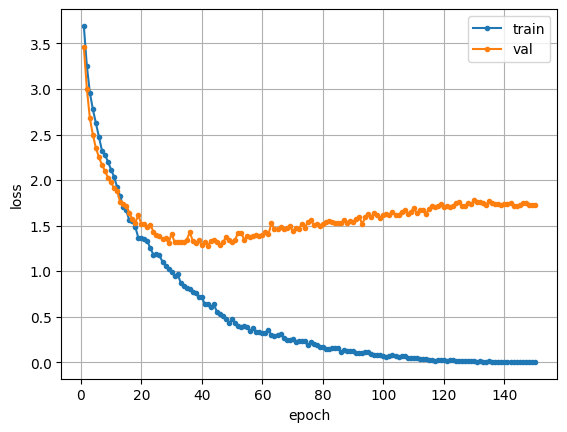

In [30]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['train loss']の長さまでの範囲）
xs = np.arange(1, len(history['train loss']) + 1)
# トレーニングデータの損失をプロット
ax.plot(xs, history['train loss'], '.-', label='train')
# バリデーションデータの損失をプロット
ax.plot(xs, history['val loss'], '.-', label='val')

ax.set_xlabel('epoch') # x軸のラベルを設定
ax.set_ylabel('loss') # y軸のラベルを設定
ax.legend() # 凡例を表示
ax.grid() # グリッドを表示
plt.show() # グラフを表示


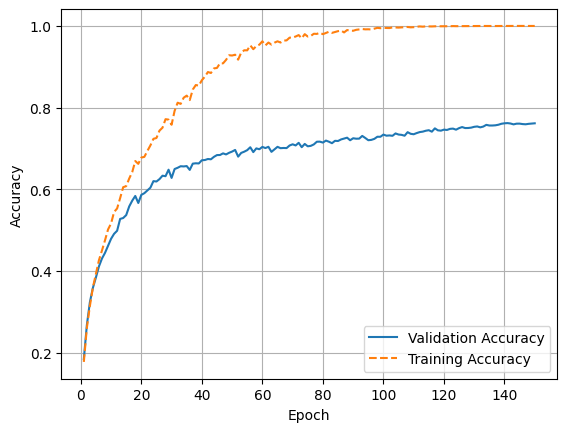

In [31]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['val acc']の長さまでの範囲）
xs = np.arange(1, len(history['val acc']) + 1)
# バリデーションデータの正解率をプロット
ax.plot(xs, history['val acc'], label='Validation Accuracy', linestyle='-')
# トレーニングデータの正解率をプロット
ax.plot(xs, history['train acc'], label='Training Accuracy', linestyle='--')
ax.set_xlabel('Epoch') # x軸のラベルを設定
ax.set_ylabel('Accuracy') # y軸のラベルを設定
ax.grid() # グリッドを表示
ax.legend()  # 凡例を追加
plt.show() # グラフを表示
